In [1]:
import pandas as pd

In [2]:
import pandas as pd

df = pd.read_csv('creditcard.csv')
print(df['Class'].value_counts())


Class
0    284315
1       492
Name: count, dtype: int64


In [8]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
# df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# # Drop the original columns
# df.drop(['Amount', 'Time'], axis=1, inplace=True)

# # Rearrange columns
# df = df[['scaled_time', 'scaled_amount'] + [col for col in df.columns if col.startswith('V')] + ['Class']]

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("creditcard.csv")

# Step 1: Scale 'Amount' and 'Time'
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df[['Amount']])
df['scaled_time'] = scaler.fit_transform(df[['Time']])

# Drop original columns
df.drop(['Amount', 'Time'], axis=1, inplace=True)

# Rearranging columns: scaled_time, scaled_amount, V1–V28, Class
df = df[['scaled_time', 'scaled_amount'] + [col for col in df.columns if col.startswith('V')] + ['Class']]

# Step 2: Split into train and test sets
X = df.drop('Class', axis=1)
y = df['Class']

# Use stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [13]:
# SMOTE (Synthetic Minority Oversampling Technique)
from imblearn.over_sampling import SMOTE

X = df.drop('Class', axis=1)
y = df['Class']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("After SMOTE:", pd.Series(y_resampled).value_counts())





After SMOTE: Class
0    284315
1    284315
Name: count, dtype: int64


In [11]:
#Random Undersampling
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X, y)

print("After Undersampling:", pd.Series(y_resampled).value_counts())


After Undersampling: Class
0    492
1    492
Name: count, dtype: int64


In [14]:
print("Original training class distribution:")
print(y_train.value_counts(normalize=True))


Original training class distribution:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64


In [15]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply to training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("After SMOTE, training class distribution:")
print(y_train_resampled.value_counts(normalize=True))


After SMOTE, training class distribution:
Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [16]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100,       # number of trees
    max_depth=None,         # tree depth (None = full growth)
    class_weight='balanced',# handle imbalance just in case
    random_state=42,
    n_jobs=-1               # use all cores
)

# Train on balanced training data
rf_model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [17]:
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # probability of class 1 (fraud)


In [18]:
from sklearn.metrics import confusion_matrix

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[56850    14]
 [   17    81]]


In [19]:
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))



Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8526    0.8265    0.8394        98

    accuracy                         0.9995     56962
   macro avg     0.9262    0.9131    0.9196     56962
weighted avg     0.9994    0.9995    0.9995     56962



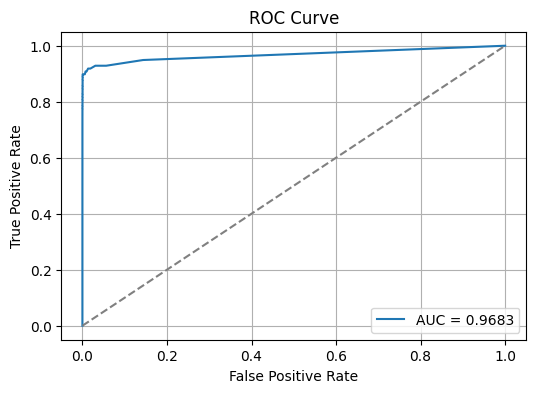

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
def test_transaction_interface(model):
    print("\n=== Fraud Detection Test Interface ===")
    print("Enter values for the following 30 features:")
    print("Format: Comma-separated values for [scaled_time, scaled_amount, V1, ..., V28]\n")

    try:
        user_input = input("Enter the 30 feature values separated by commas:\n> ")

        # Convert input to a list of floats
        features = [float(i.strip()) for i in user_input.split(',')]

        if len(features) != 30:
            print(f"❌ You entered {len(features)} values. Expected 30 features.")
            return

        # Reshape to match model input
        features_array = np.array(features).reshape(1, -1)

        # Predict
        prediction = model.predict(features_array)[0]
        proba = model.predict_proba(features_array)[0][1]

        # Output result
        print("\n📊 Prediction:")
        if prediction == 1:
            print(f"⚠️  This transaction is predicted to be **FRAUDULENT** (confidence: {proba:.2%})")
        else:
            print(f"✅ This transaction is predicted to be **LEGITIMATE** (confidence: {1 - proba:.2%})")

    except Exception as e:
        print("⚠️ Error:", e)


In [28]:
test_transaction_interface(rf_model)



=== Fraud Detection Test Interface ===
Enter values for the following 30 features:
Format: Comma-separated values for [scaled_time, scaled_amount, V1, ..., V28]


📊 Prediction:
✅ This transaction is predicted to be **LEGITIMATE** (confidence: 94.00%)


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
